#Metoda podpornih vektorjev: dualna oblika

Pri spodnji implementaciji metode podpornih vektorjem izhajamo iz njene dualne oblike. Uporabljamo jedra. Za optimizacijo parametrov uporabimo stohastični gradientni spust, kar ni preveč posrečeno, saj ti pristop v osnovi pri popravljanju enega samega parametra krši pogoje Karush-Kuhn-Tucker, ki naj bi veljali zato, da bi rešitev dualne oblike enaki rešitvi primarne. K sreči nam ta malomarnost ne škoduje prav veliko in postopek še vedno vrača smiselne rezultate. "Pravi" algoritmi za SVM sicer uporabljajo optimizacijo z imenom [sequential minimal optimization](http://en.wikipedia.org/wiki/Sequential_minimal_optimization).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
import Orange
%matplotlib inline

Pripravimo dva različna podatkovna nabora, enega primernega za linearno odločitveno ravnino, druga pa z bolj kompleksno ločnico med razredi.

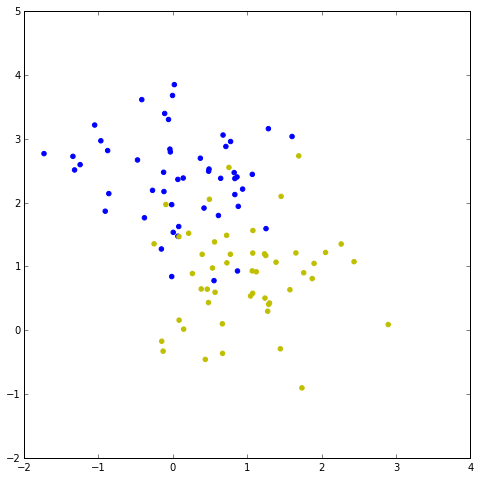

In [2]:
colors = np.array(['b', 'y'])
markers = ["_", "+"]
X, y = datasets.make_blobs(n_samples=100, centers=[[0, 2.3], [1, 1]], 
                           cluster_std=0.7)
blobs = Orange.data.Table(X, y)

X = (np.random.rand(500, 2)-0.5) * 20
y = (np.sqrt(np.sum(X**2, axis=1)) > 8).astype(int)
circle = Orange.data.Table(X, y)

data = blobs  # blobs ali circle, nastavimo, katere podatke bi radi uporabili
plt.figure(figsize=(8,8))
plt.scatter(data.X[:, 0], data.X[:, 1], color=colors[data.Y.astype(int)], s=20);

Implementacija metode podpornih vektorjev, ki uporablja jedra.

In [3]:
def add_ones(X):
    return np.column_stack((np.ones(len(X)), X))
    
class SVMLearner(Orange.classification.Learner):
    def __init__(self, C=1, kernel="rbf"):
        super().__init__()
        self.C = C
        self.name = "svm"
        self.cache = {}
        self.kernel = {"rbf": self.kernel_rbf,
                       "linear": self.kernel_linear}[kernel]
        
    def kernel_linear(self, a, b):
        return a.dot(b.T)
    
    def kernel_rbf(self, a, b, sigma=10):
        return np.exp(-np.linalg.norm(a-b, axis=1)**2/(2*sigma))
        
    def k(self, i):
        if i in self.cache:
            return self.cache[i]
        res = self.kernel(self.X[i], self.X)
        self.cache[i] = res
        return res
    
    def predict(self, x):
        if len(x.shape)>1:
            res = np.array([np.sum(self.a * self.y * self.kernel(xp, self.X)) 
                            for xp in x])
        else:
            res = np.sum(self.a * self.y * self.kernel(x, self.X), axis=1)
        return np.ones(x.shape[0]) * (res >= 0)
        
    def fit_storage(self, data, epochs=200, rate=0.001):
        self.X = add_ones(data.X)
        self.y = (data.Y - 0.5) * 2
        self.a = np.zeros(self.X.shape[0])
        indices = np.arange(self.X.shape[0])
        np.random.shuffle(indices)
        for epoch in range(epochs):
            for i in indices:
                upd = 1 - self.y[i] * np.sum(self.a * self.y * self.k(i))
                self.a[i] = min(self.C, max(0, self.a[i] + rate * upd))
        return SVMModel(self.a, self.predict)
        
class SVMModel(Orange.classification.Model):
    """Classifier for gradient boosting."""
    def __init__(self, a, p):
        self.a = a
        self.p = p
    
    def predict(self, X):
        """Given a data instance or table of data instances returns predicted class."""
        X = add_ones(X)
        return self.p(X)

In [4]:
svm = SVMLearner(C=1, kernel="rbf")
model = svm(data)
model(data[0:5]), data.Y[0:5]

(array([ 1.,  0.,  1.,  1.,  0.]), array([ 1.,  0.,  1.,  1.,  0.]))

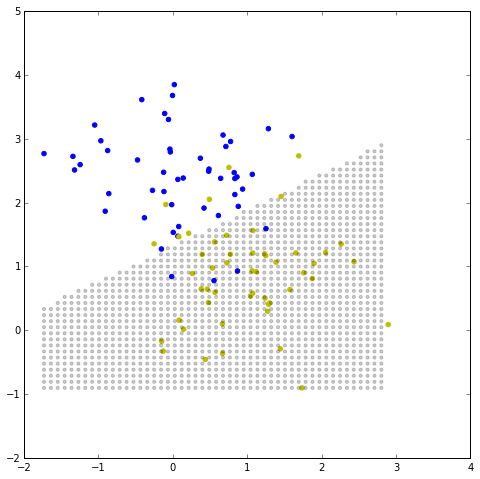

In [5]:
minx, miny = np.min(data.X, axis=0)
maxx, maxy = np.max(data.X, axis=0)

n = 50
G = np.array([(x, y) for x in np.arange(minx, maxx, (maxx-minx)/n) 
              for y in np.arange(miny, maxy, (maxy-miny)/n)])
y_hat = model(G)

plt.figure(figsize=(8,8))
plt.scatter(data.X[:, 0], data.X[:, 1], color=colors[data.Y.astype(int)], s=20)
plt.scatter(G[:, 0], G[:, 1], s=y_hat*10, color="k", alpha=0.2);